In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
from keras.models import Model,Sequential
from keras.layers import  LSTM
from keras.layers.core import Activation, Dropout, Dense
from sklearn.model_selection import train_test_split
from sklearn.linear_model import (LinearRegression,Lasso,Ridge,ElasticNet,HuberRegressor,Lars,LassoLars,
                                  PassiveAggressiveRegressor,RANSACRegressor,SGDRegressor)
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor
from sklearn.metrics import  mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose 
from pmdarima import auto_arima                        
from statsmodels.tools.eval_measures import rmse
import warnings
warnings.filterwarnings("ignore")
import itertools

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [5]:
df = pd.read_csv('Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [6]:
df.Date = pd.to_datetime(df.Date, dayfirst=True)

In [7]:
df.sort_values('Date',inplace=True)

In [8]:
df.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
138707,Materials,2260,Sahara Petrochemical Co.,2009-01-03,12.15,12.90,12.10,12.85,0.80,6.63,2617351,32610608.60,989
237007,Retailing,4050,Saudi Automotive Services Co.,2009-01-03,11.75,12.15,11.75,12.05,0.50,4.32,2767819,33195157.05,1206
73500,Materials,2020,Saudi Arabian Fertilizer Co.,2009-01-03,92.00,98.50,92.00,98.50,8.75,9.74,871456,84833829.25,999
407889,Insurance,8180,Al Sagr Cooperative Insurance Co.,2009-01-03,12.15,13.25,12.15,13.25,1.15,9.50,2091187,26429787.35,1209


In [9]:
df['Company Name'].groupby(df['Industry Group']).value_counts()

Industry Group  Company Name                           
Banks           Al Rajhi Bank                              2722
                Alinma Bank                                2722
                Arab National Bank                         2722
                Bank Albilad                               2722
                Bank Aljazira                              2722
                                                           ... 
Transportation  Saudi Public Transport Co.                 2722
                United International Transportation Co.    2722
                Saudi Ground Services Co.                  1102
Utilities       National Gas and Industrialization Co.     2722
                Saudi Electricity Co.                      2722
Name: Company Name, Length: 205, dtype: int64

In [10]:
TaibaـInvestments = df[df['Company Name']== 'Taiba Investments Co.']

In [11]:
TaibaـInvestments_for_model = TaibaـInvestments[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [12]:
TaibaـInvestments_for_model.head(4)

,Date,Open,High,Low,Close,Change,% Change
247896,2009-01-03,17.70,18.05,17.70,17.95,0.30,1.69
247894,2009-01-04,17.95,18.05,17.85,18.00,0.05,0.27
247891,2009-01-05,18.05,18.20,17.95,18.20,0.20,1.11
247892,2009-01-06,18.15,18.40,18.00,18.10,-0.10,-0.54


In [13]:
TaibaـInvestments_for_model.reset_index(inplace=True)

In [15]:

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(TaibaـInvestments_for_model["Date"][-(227):])[0]

In [16]:
split_date

Timestamp('2019-01-01 00:00:00')

In [17]:
TaibaـInvestments_for_arima = TaibaـInvestments_for_model[['Date', 'Open', 'High', 'Low', 'Close', 'Change', '% Change']]

In [18]:
TaibaـInvestments_for_arima.set_index('Date',inplace=True)

In [19]:
training_set, test_set = TaibaـInvestments_for_model[TaibaـInvestments_for_model['Date'] < split_date], TaibaـInvestments_for_model[TaibaـInvestments_for_model['Date'] >= split_date]


In [20]:
training_set.shape

(2495, 8)

In [21]:
test_set.shape

(227, 8)

In [22]:
test_set.set_index('Date',inplace=True)

In [23]:
training_set.set_index('Date',inplace=True)

In [24]:
training_set = training_set.drop(['index'], 1)
test_set = test_set.drop(['index'], 1)

In [25]:
training = training_set.values

In [26]:
testing = test_set.values

## LSTM

## Window length

In [27]:
window_len = 5

LSTM_training_inputs = []
for i in range(len(training)-window_len):
    temp_set = training[i:(i+window_len)].copy()
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = training_set['Close'][window_len:].values
LSTM_training_inputs = np.array(LSTM_training_inputs)


#Create windows for testing
LSTM_test_inputs = []
for i in range(len(testing)-window_len):
    temp_set1 = testing[i:(i+window_len)].copy()
    LSTM_test_inputs.append(temp_set1)
LSTM_test_outputs = test_set['Close'][window_len:].values
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [28]:
LSTM_test_inputs.shape

(222, 5, 6)

In [29]:
LSTM_training_inputs.shape

(2490, 5, 6)

In [30]:
# If you want to reste the model 
# nn_model.reset_states()
# nn_model.reset_metrics()

In [31]:
def build_model(inputs, output_size, neurons, activ_func="relu",
                dropout=0.10, loss="mae", optimizer="adam"):
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [32]:

nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 400)

nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=120, batch_size=160, verbose=1,validation_split= 0.2)

Train on 1992 samples, validate on 498 samples
Epoch 1/120
1992/1992 [==============================] - 2s 980us/step - loss: 19.3447 - val_loss: 18.8423
Epoch 2/120
1992/1992 [==============================] - 1s 446us/step - loss: 10.8598 - val_loss: 13.2849
Epoch 3/120
1992/1992 [==============================] - 1s 488us/step - loss: 9.9439 - val_loss: 11.3503
Epoch 4/120
1992/1992 [==============================] - 1s 496us/step - loss: 9.5433 - val_loss: 10.4700
Epoch 5/120
1992/1992 [==============================] - 1s 496us/step - loss: 8.9970 - val_loss: 9.9862
Epoch 6/120
1992/1992 [==============================] - 1s 495us/step - loss: 8.3553 - val_loss: 8.8444
Epoch 7/120
1992/1992 [==============================] - 1s 490us/step - loss: 7.3877 - val_loss: 7.8229
Epoch 8/120
1992/1992 [==============================] - 1s 501us/step - loss: 5.7027 - val_loss: 5.8378
Epoch 9/120
1992/1992 [==============================] - 1s 488us/step - loss: 3.5742 - val_loss: 3.6913
Ep

Epoch 78/120
1992/1992 [==============================] - 1s 387us/step - loss: 0.6052 - val_loss: 0.5375
Epoch 79/120
1992/1992 [==============================] - 1s 389us/step - loss: 0.6243 - val_loss: 0.3170
Epoch 80/120
1992/1992 [==============================] - 1s 378us/step - loss: 0.5997 - val_loss: 0.4165
Epoch 81/120
1992/1992 [==============================] - 1s 337us/step - loss: 0.5967 - val_loss: 0.3535
Epoch 82/120
1992/1992 [==============================] - 1s 366us/step - loss: 0.6036 - val_loss: 0.4106
Epoch 83/120
1992/1992 [==============================] - 1s 357us/step - loss: 0.5928 - val_loss: 0.3639
Epoch 84/120
1992/1992 [==============================] - 1s 363us/step - loss: 0.5919 - val_loss: 0.3242
Epoch 85/120
1992/1992 [==============================] - 1s 371us/step - loss: 0.5990 - val_loss: 0.3167
Epoch 86/120
1992/1992 [==============================] - 1s 368us/step - loss: 0.5892 - val_loss: 0.3809
Epoch 87/120
1992/1992 [======================

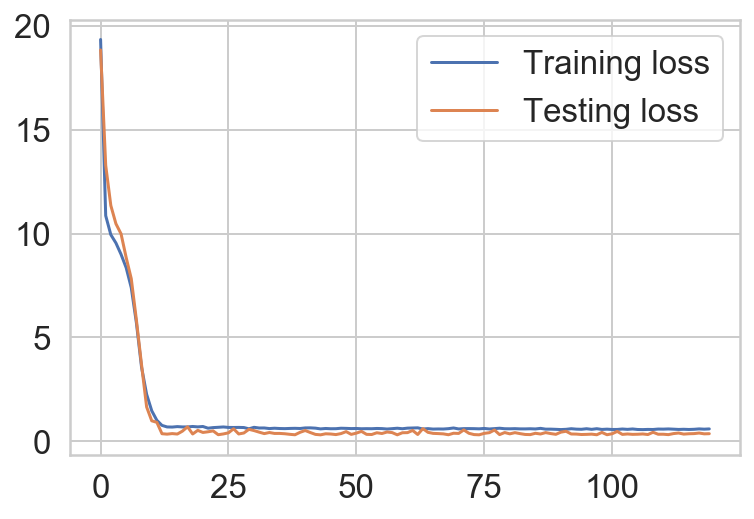

In [33]:
train_loss = nn_history.history['loss']
test_loss = nn_history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

In [34]:
#Reshape from 3D array to 2D array to fit the other models 
X_train = LSTM_training_inputs.reshape((2490,30))
X_test = LSTM_test_inputs.reshape((222,30))

## ARIMA

In [35]:
y = TaibaـInvestments_for_arima['Close'].resample('MS').mean()

In [36]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [37]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
        except:
            continue
        results = mod.fit()
        print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1266.9344138012298
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1042.867778596041
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:896.3707010284419
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:826.1334592266847
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:755.2094371738609
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:681.4445203809772
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:822.0994734394834
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:697.8204195459272
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:617.2313225729257
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:834.0990419204959
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:829.8493909325665
ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:757.0982295475211
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:761.3366371617273
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:757.202474229907
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:676.1945319397313
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:726.2366314828053
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:699.8017060399897
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:618.8133453086159
ARIMA(0, 0

ARIMA(0, 1, 2)x(1, 1, 2, 12)12 - AIC:387.80093139974264
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:493.8911882659627
ARIMA(0, 1, 2)x(1, 2, 1, 12)12 - AIC:439.65619286765855
ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:382.8845253431101
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:429.21877402197316
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:431.0400349653934
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:421.9726648340459
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:419.94998992106343
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:404.2009707491693
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:388.9120487794031
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:427.07177929410955
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:404.7924018533432
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:385.3671224277255
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:556.9400547359086
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:512.0525570943869
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:471.9616060342223
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:609.2568151986408
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:486.46143321489836
ARIM

ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:461.44614770511197
ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:425.86120127256146
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:545.0103287618283
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:435.0053327747304
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:397.4632776726893
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:617.1413928904167
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:473.0683257933766
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:424.0526400727678
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:465.4105379667748
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:461.5909876050825
ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:427.47467698880007
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:465.73971318350635
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:437.00507358147047
ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:391.6620430737195
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:492.19715223956905
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:444.1101092902426
ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:390.58013524212174
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:431.2187384035886
ARI

ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:489.57065399034514
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:445.28758834670464
ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:386.5834572445826
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:426.34195826740654
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:428.07461561902005
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:425.8229987202503
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:416.23694390010144
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:398.99078449648755
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:392.9862203809673
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:422.3603925649918
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:401.3509626646098
ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:389.48326277151955
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:490.8910485609948
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:456.50658019502
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:421.55065171032936
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:543.7616504444461
ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:434.8388927915761
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:392.0151502933578
ARIM

ARIMA(2, 1, 1)x(0, 0, 2, 12)12 - AIC:425.7638148888022
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:548.791446747983
ARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:436.9838341320581
ARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:396.62453142847363
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:622.4147269726866
ARIMA(2, 1, 1)x(0, 2, 1, 12)12 - AIC:476.48160776873925
ARIMA(2, 1, 1)x(0, 2, 2, 12)12 - AIC:384.2527590545393
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:459.5494337133903
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:461.49543750720375
ARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:427.50754084755874
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:460.78774506045636
ARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:441.19091651559916
ARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:393.4494836361259
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:487.393330442068
ARIMA(2, 1, 1)x(1, 2, 1, 12)12 - AIC:446.001648577928
ARIMA(2, 1, 1)x(1, 2, 2, 12)12 - AIC:390.1721847807498
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:425.1878646432526
ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:427.0340172169667
ARIMA(2

In [88]:
#ARIMA(1, 2, 0)x(2, 2, 1, 12)12 - AIC:423.38285429627

mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1,2,0),
                                seasonal_order=(2,2,1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3791      0.100     -3.804      0.000      -0.574      -0.184
ar.S.L12      -0.7462      0.148     -5.029      0.000      -1.037      -0.455
ar.S.L24      -0.2237      0.162     -1.381      0.167      -0.541       0.094
ma.S.L12      -1.0000   5561.802     -0.000      1.000   -1.09e+04    1.09e+04
sigma2         7.6305   4.24e+04      0.000      1.000   -8.32e+04    8.32e+04


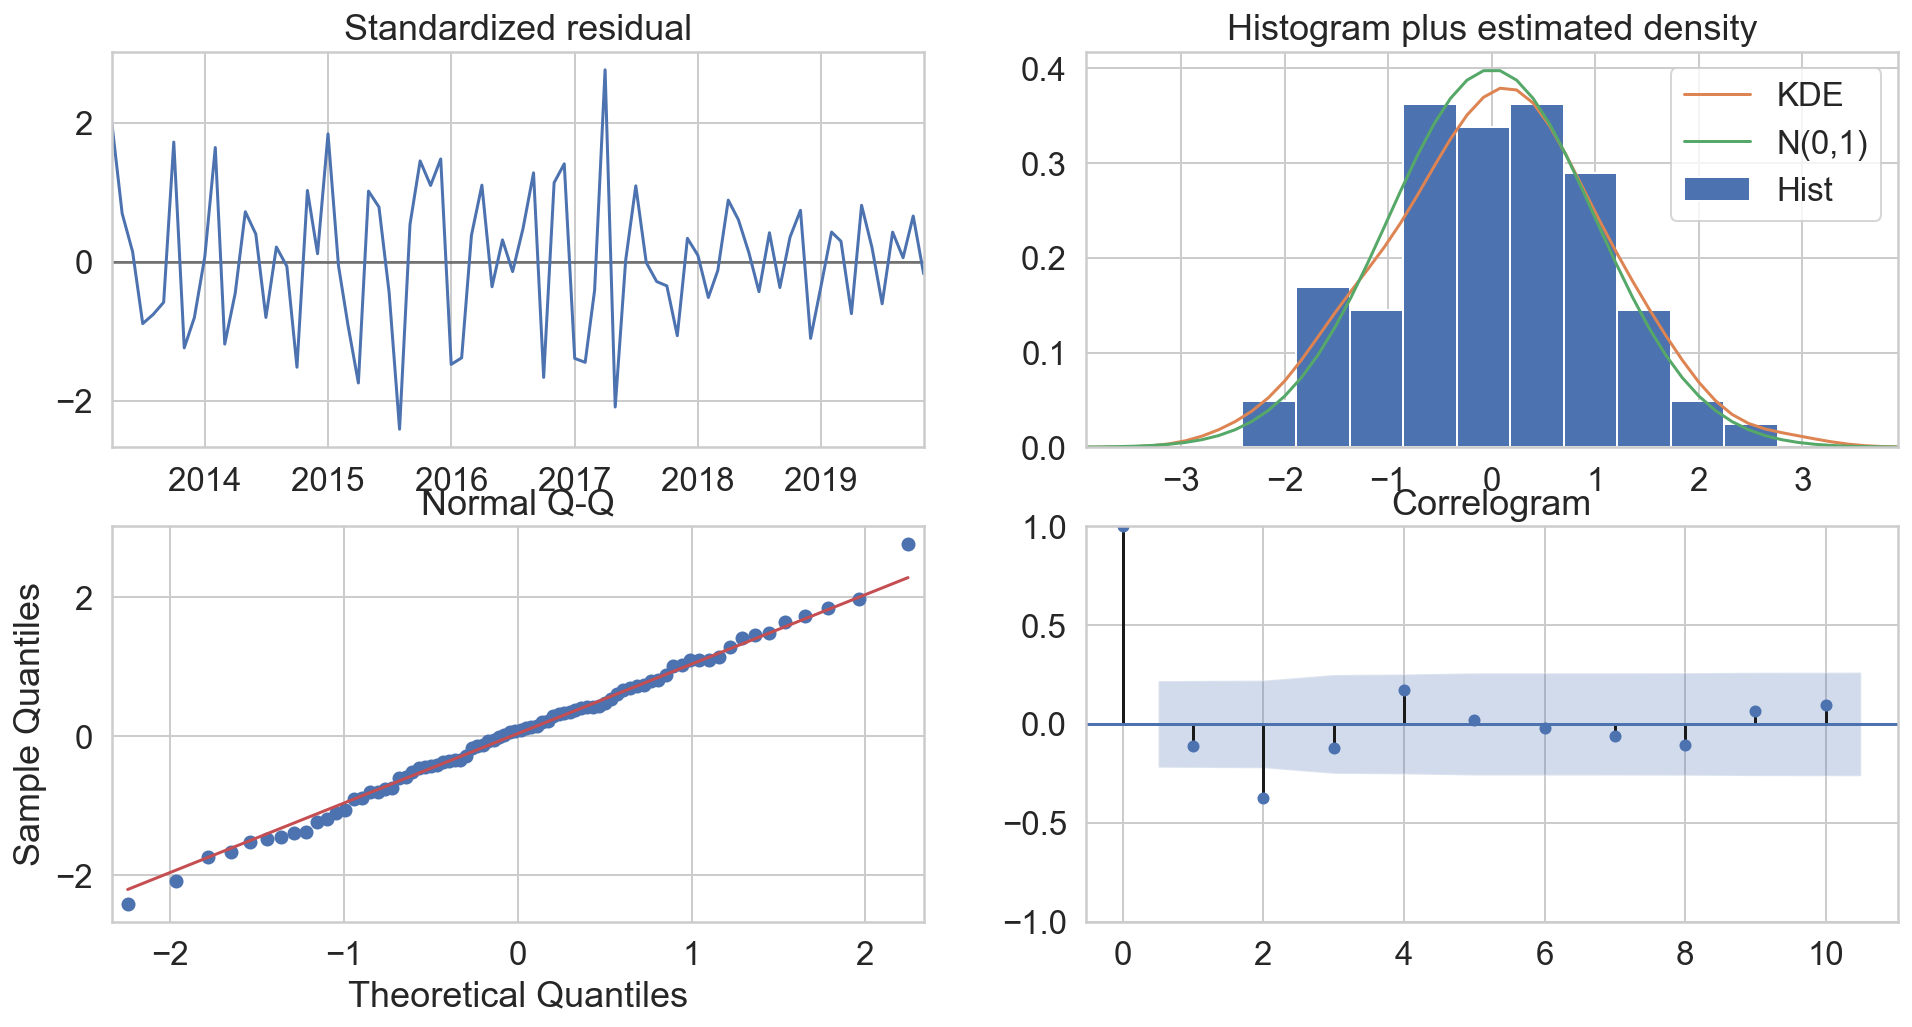

In [89]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

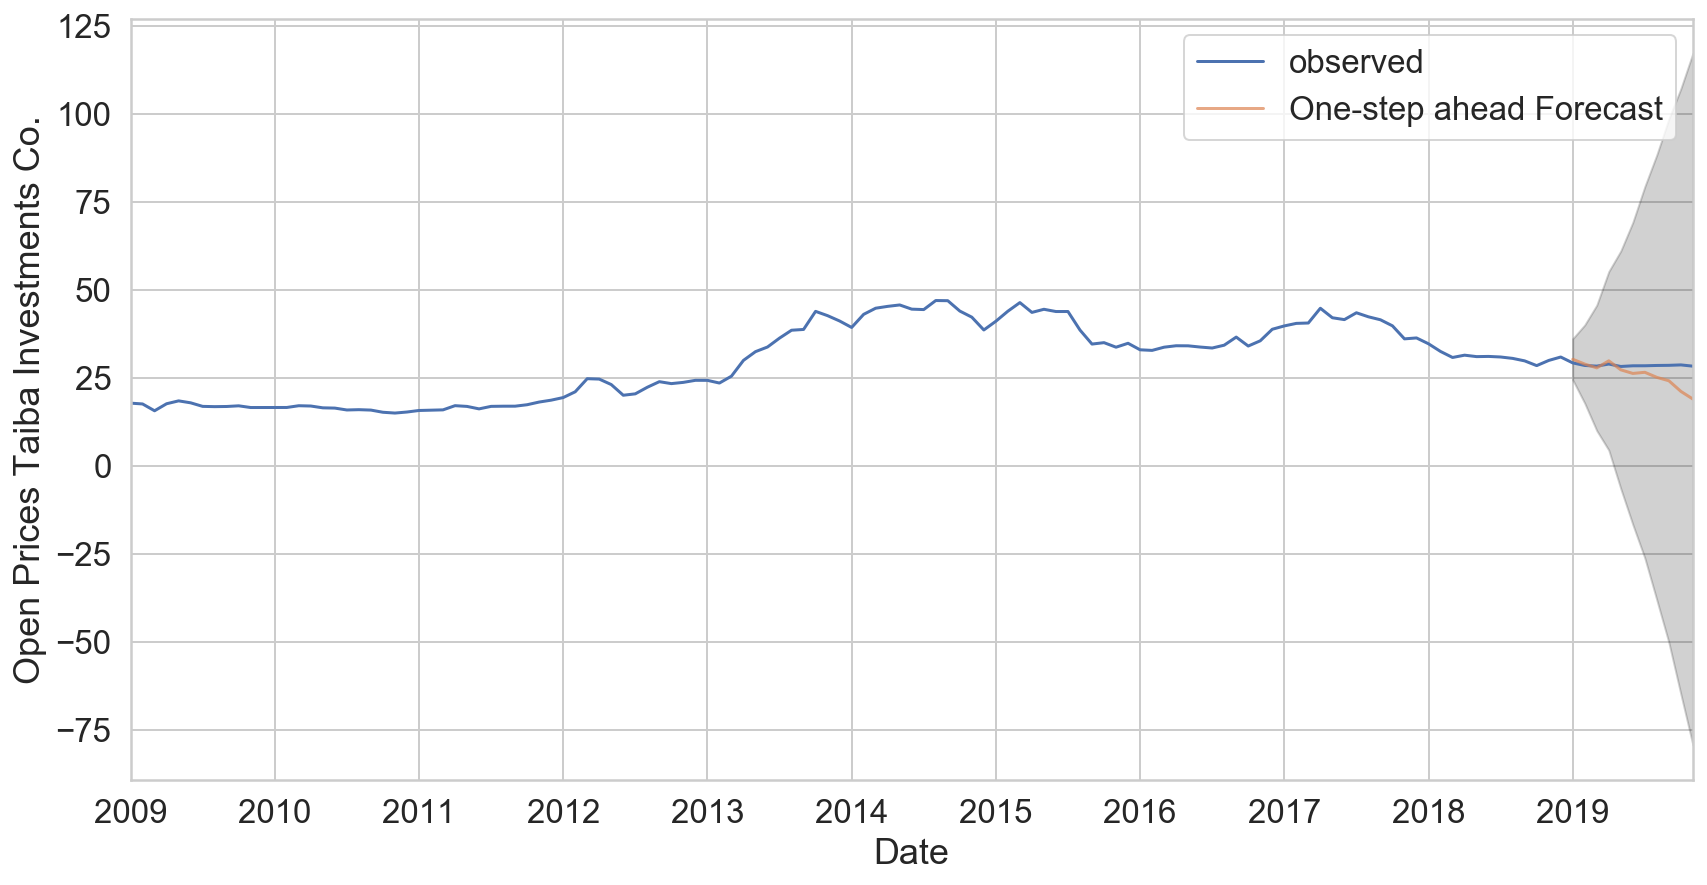

In [90]:
#Here i choose the start of 2019
pred = results.get_prediction(start=pd.to_datetime('2019-01-01'), dynamic=True)
pred_ci = pred.conf_int()
ax = y['2009':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Open Prices Taiba Investments Co.')
plt.legend()
plt.show()

In [91]:
y_forecasted = pred.predicted_mean
y_truth = y['2019-01-01':]
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 16.94


In [92]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 4.12


## Producing and visualizing forecasts

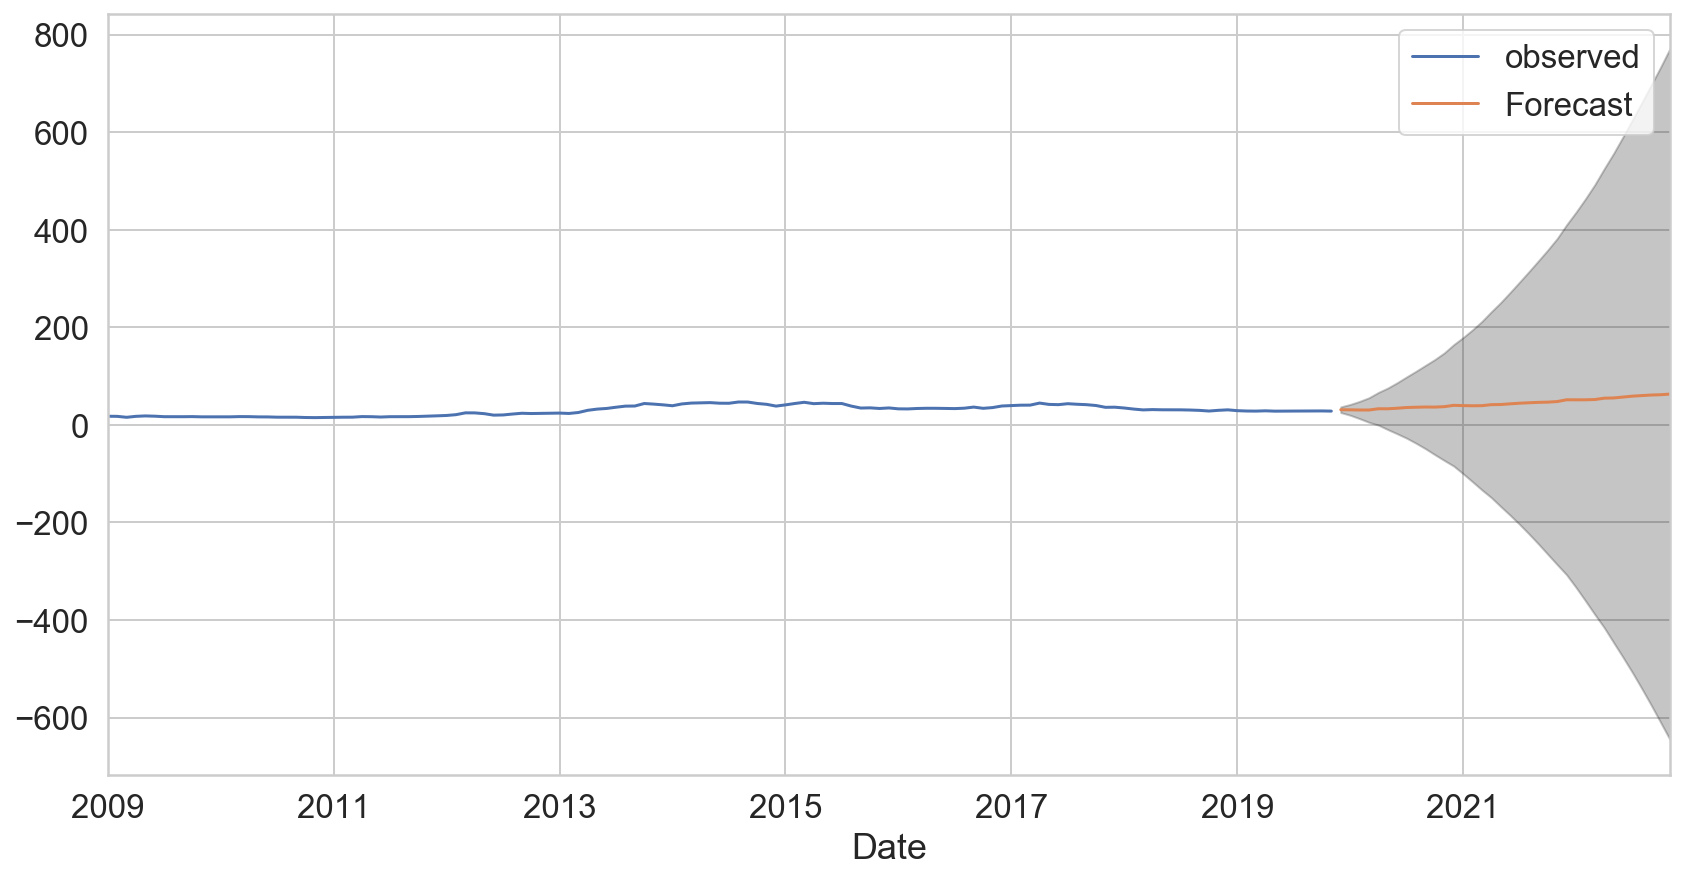

In [93]:
pred_uc = results.get_forecast(steps=36)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
plt.legend()
plt.show()

## Model 

In [94]:
gboost  = GradientBoostingRegressor()
rt      = RandomForestRegressor()
lr      = LinearRegression()
lasso   = Lasso()
ridge   = Ridge()
en      = ElasticNet()
huber   = HuberRegressor()
lars    = Lars()

pa      = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
ranscac = RANSACRegressor()

mod = [lr, lasso, ridge, en, huber, lars, pa, ranscac, gboost, rt,# llars, sgd
      ]

In [95]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    model.predict(X_train)
    model.predict(X_test)


In [96]:
for i in mod:
     evaluate_model(i,X_train, LSTM_training_outputs, X_test, LSTM_test_outputs)

In [97]:
LSTM_pred = nn_model.predict(LSTM_test_inputs).T[0]

In [98]:
Lr_train_pred = lr.predict(X_train)
Lr_test_pred = lr.predict(X_test)
Lasso_train_pred = lasso.predict(X_train)
Lasso_test_pred = lasso.predict(X_test)
Ridge_train_pred = ridge.predict(X_train)
Ridge_test_pred = ridge.predict(X_test)
ElasticNet_train_pred = en.predict(X_train)
ElasticNet_test_pred = en.predict(X_test)
HuberRegressor_train_pred = huber.predict(X_train)
HuberRegressor_test_pred = huber.predict(X_test)
Lars_train_pred = lars.predict(X_train)
Lars_test_pred = lars.predict(X_test)

PassiveAggressiveRegressor_train_pred = pa.predict(X_train)
PassiveAggressiveRegressor_test_pred = pa.predict(X_test)
RANSACRegressor_train_pred = ranscac.predict(X_train)
RANSACRegressor_test_pred = ranscac.predict(X_test)

GradientBoostingRegressor_train_pred = gboost.predict(X_train)
GradientBoostingRegressor_test_pred = gboost.predict(X_test)
RandomForestRegressor_train_pred  = rt.predict(X_train)
RandomForestRegressor_test_pred  = rt.predict(X_test)

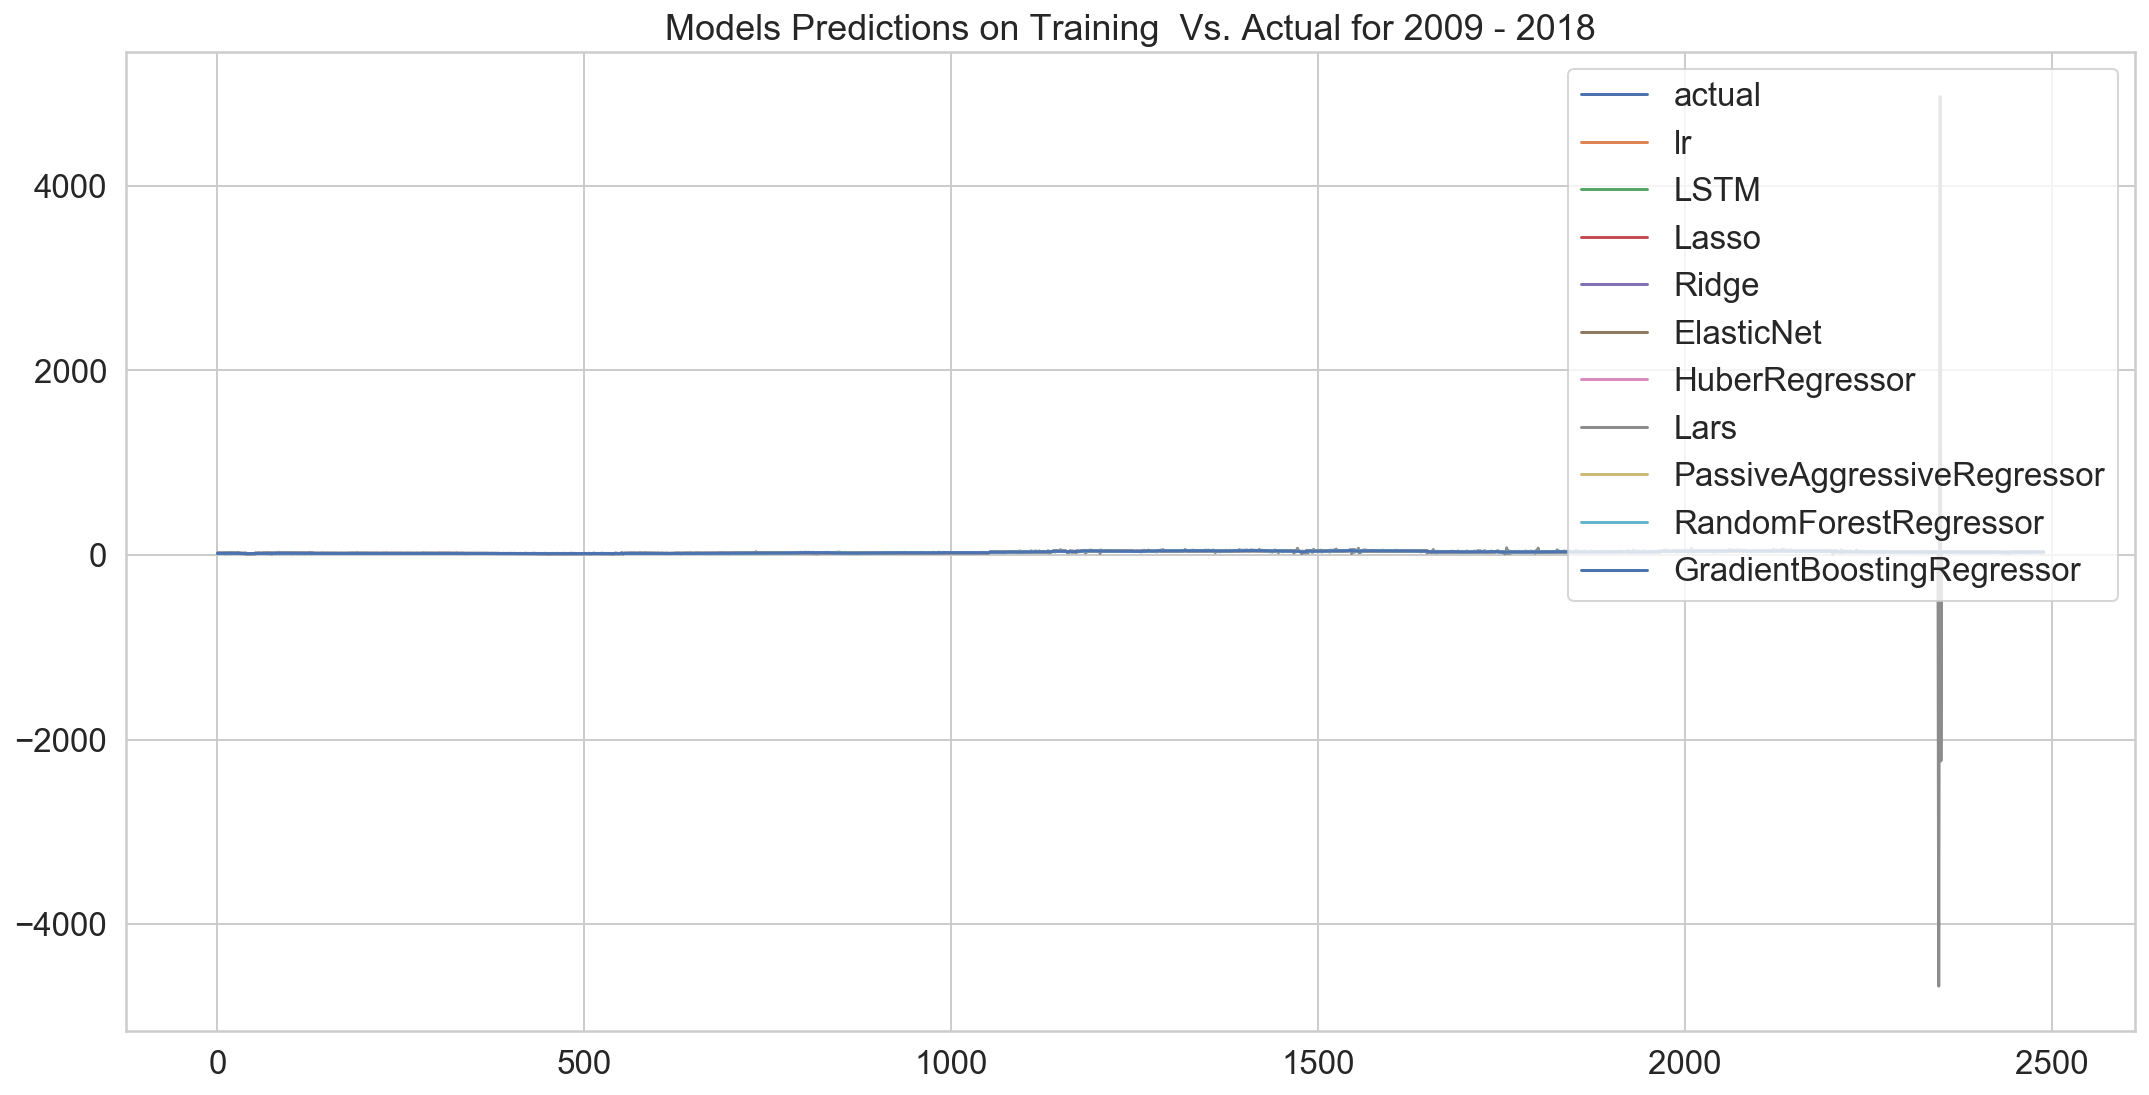

In [99]:
fig = plt.subplots( figsize=(18,9))
plt.plot(LSTM_training_outputs, label = "actual")
plt.plot(Lr_train_pred, label = "lr")
plt.plot(nn_model.predict(LSTM_training_inputs), label = "LSTM")
plt.plot(Lasso_train_pred, label = "Lasso")
plt.plot(Ridge_train_pred, label = "Ridge")
plt.plot(ElasticNet_train_pred, label = "ElasticNet")
plt.plot(HuberRegressor_train_pred, label = "HuberRegressor")
plt.plot(Lars_train_pred, label = "Lars")
# 
plt.plot(PassiveAggressiveRegressor_train_pred, label = "PassiveAggressiveRegressor")
plt.plot(RandomForestRegressor_train_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_train_pred, label = "GradientBoostingRegressor")
# plt.plot(RANSACRegressor_tradin_pred, label = "RANSACRegressor")

plt.title('Models Predictions on Training  Vs. Actual for 2009 - 2018')
plt.legend()
plt.show()

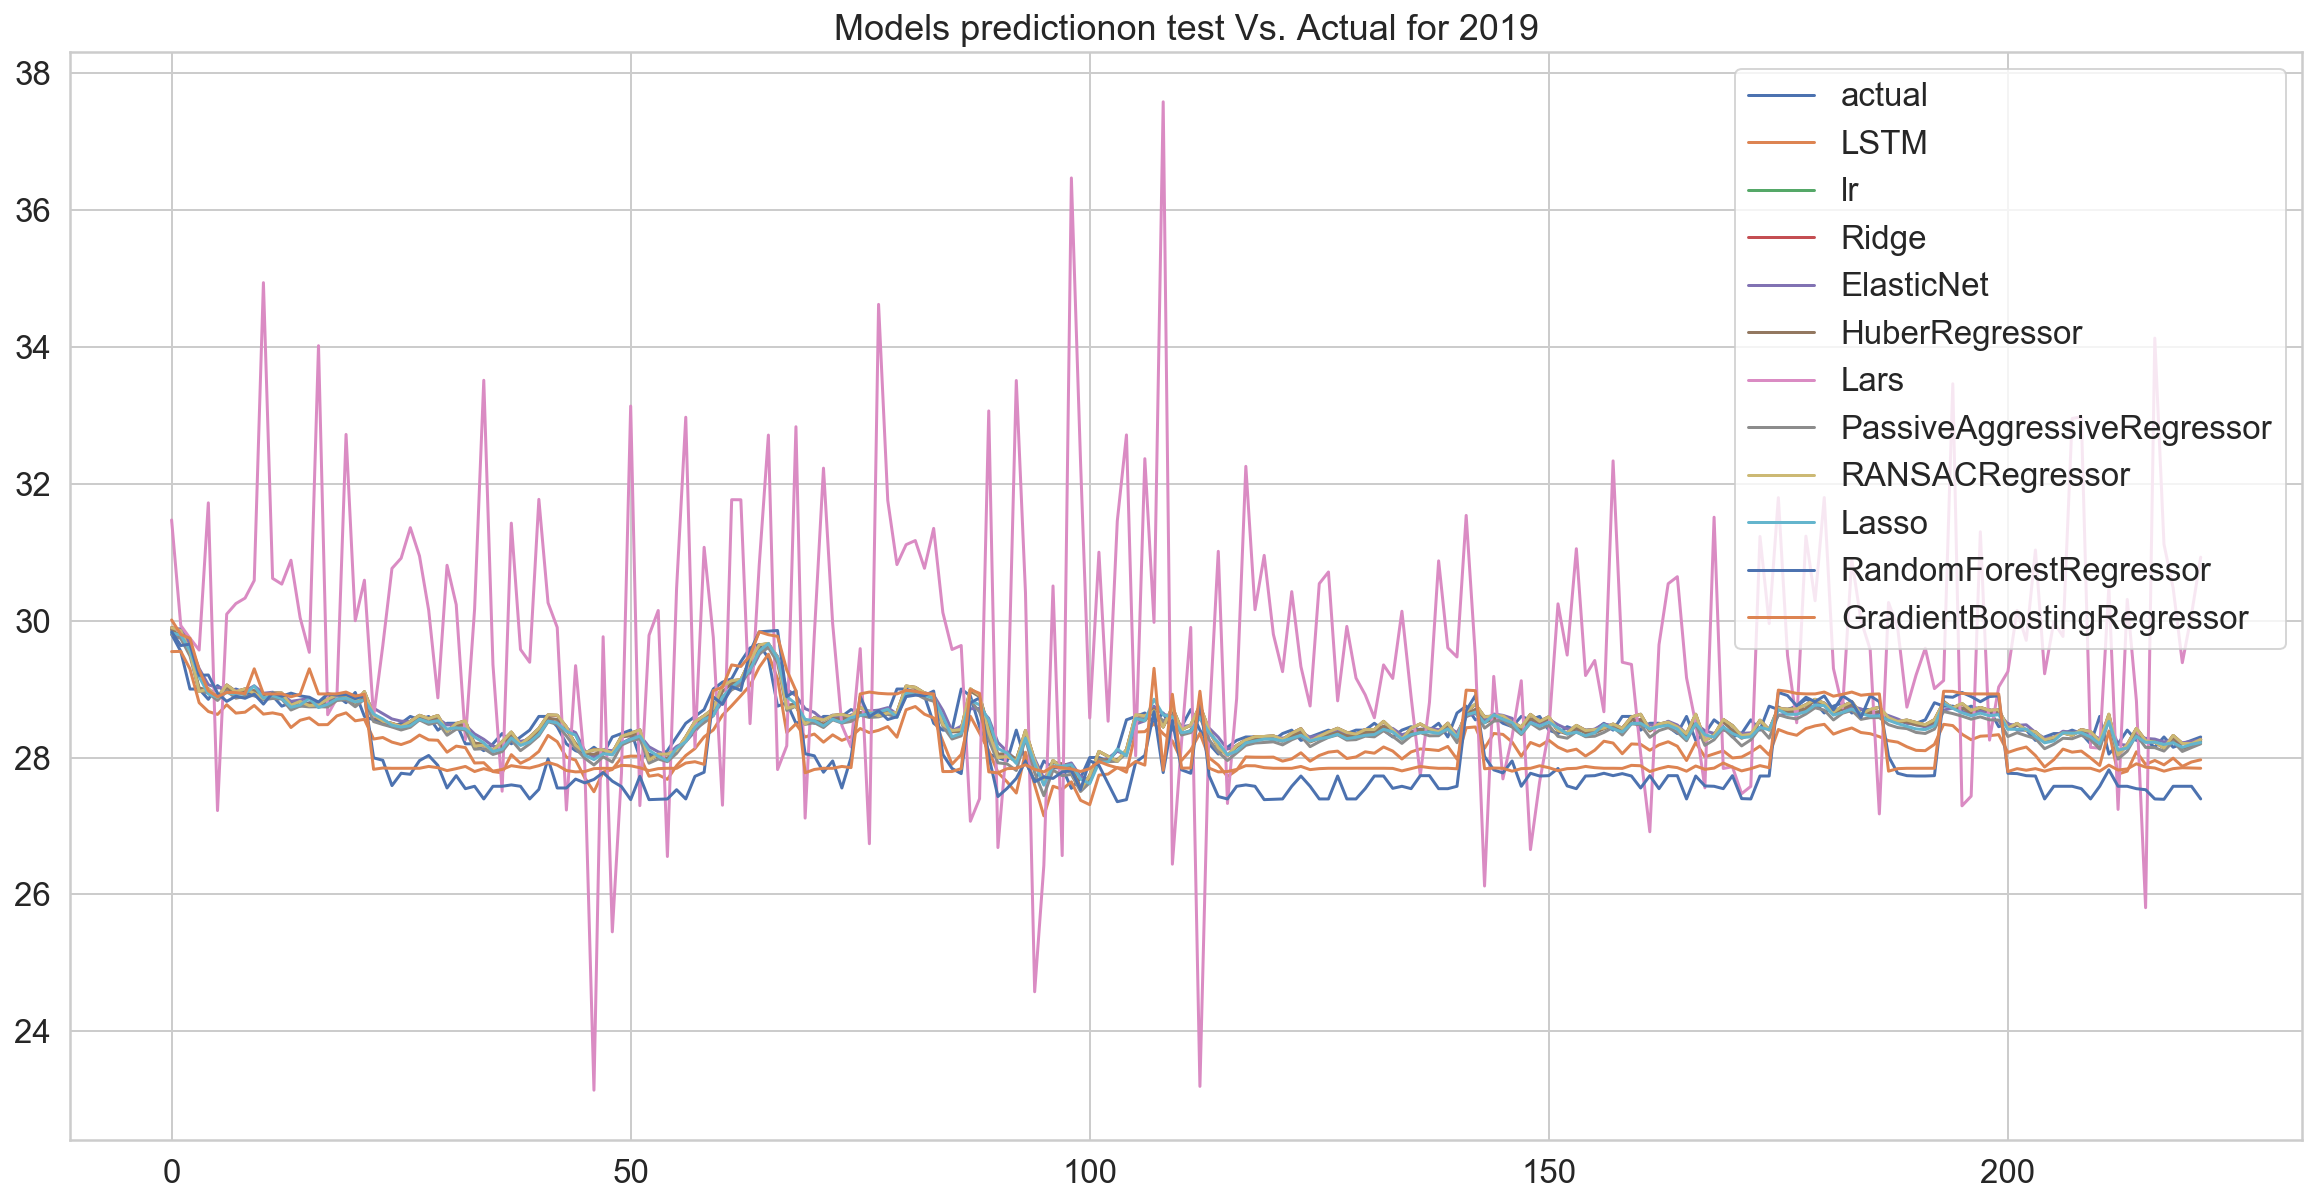

In [100]:
fig = plt.subplots( figsize=(20,10))
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "LSTM")
plt.plot(Lr_test_pred, label = "lr")
plt.plot(Ridge_test_pred, label = "Ridge")
plt.plot(ElasticNet_test_pred, label = "ElasticNet")
plt.plot(HuberRegressor_test_pred, label = "HuberRegressor")
plt.plot(Lars_test_pred, label = "Lars")

plt.plot(PassiveAggressiveRegressor_test_pred, label = "PassiveAggressiveRegressor")
plt.plot(RANSACRegressor_test_pred, label = "RANSACRegressor")

plt.plot(Lasso_test_pred, label = "Lasso")
plt.plot(RandomForestRegressor_test_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_test_pred, label = "GradientBoostingRegressor")
plt.title('Models predictionon test Vs. Actual for 2019')
plt.legend(loc=1)
plt.show()

In [101]:
predictions_test = pd.DataFrame({'Actual' : LSTM_test_outputs,
                                'Lr' : Lr_test_pred,
                                'Lasso' :Lasso_test_pred  ,
                                'Ridge':Ridge_test_pred ,
                                'ElasticNet' :ElasticNet_test_pred ,
                                'PassiveAggressiveRegressor' :PassiveAggressiveRegressor_test_pred  ,
                                'HuberRegressor': HuberRegressor_test_pred,
                                'Lars' : Lars_test_pred,
                                'RANSACRegressor' : RANSACRegressor_test_pred ,
                                'LSTM':LSTM_pred,
                                'GradientBoostingRegressor':GradientBoostingRegressor_test_pred,
                                'RandomForestRegressor':RandomForestRegressor_test_pred
                                }, 
                                columns=['Actual','Lr','Lasso', 'Ridge','ElasticNet','PassiveAggressiveRegressor',
                                        'HuberRegressor','Lars','RANSACRegressor','LSTM',  'RandomForestRegressor',
                                       'GradientBoostingRegressor' ])

In [102]:
predictions_test.head()

,Actual,Lr,Lasso,Ridge,ElasticNet,PassiveAggressiveRegressor,HuberRegressor,Lars,RANSACRegressor,LSTM,RandomForestRegressor,GradientBoostingRegressor
0,29.80,29.897488,29.818559,29.896625,29.874778,29.796275,29.861587,31.468601,29.895284,29.546616,29.835,30.008615
1,29.55,29.854345,29.789934,29.853433,29.879538,29.738532,29.777513,29.927219,29.853029,29.549395,29.635,29.797128
2,29.00,29.538421,29.559736,29.537922,29.658870,29.482942,29.535266,29.742543,29.542317,29.292620,29.655,29.741424
3,29.00,28.968813,29.179089,28.968878,29.298997,28.977367,29.016528,29.569095,28.963632,28.799789,29.200,29.276767
4,28.85,29.003111,28.926478,29.003069,29.062635,28.938319,28.980724,31.718503,29.003028,28.672031,29.205,28.975048


## Validating our model

In [103]:
df_new = pd.read_csv('NEWW-Equites_Historical_NonAdjusted_Prices.csv', usecols=['Industry Group', 'Symbol', 
                                                                       'Company Name', 'Date', 'Open', 'High',
                                                                       'Low', 'Close', 'Change', '% Change', 
                                                                       'Volume Traded','Value Traded (SAR)', 
                                                                       'No. of Trades'])

In [104]:
df_new.Date = pd.to_datetime(df.Date, dayfirst=True)

In [105]:
df_new.sort_values('Date',inplace=True)

In [106]:
df_new.head(4)

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
2121,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-03,17.06,17.06,16.78,16.90,-0.26,-1.52,147529,2494172.96,325
2123,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-04,17.38,17.38,17.18,17.18,-0.20,-1.15,142735,2465908.84,205
2133,Insurance,8290,Solidarity Saudi Takaful Co.,2009-01-05,10.32,10.36,10.30,10.34,-0.02,-0.19,47405,489919.30,106
2118,Insurance,8280,Al Alamiya for Cooperative Insurance Co.,2009-01-06,17.42,17.54,17.40,17.50,0.00,0.00,117410,2049337.42,222


In [107]:
TaibaـInvestments_2_weeks = df_new[df_new['Company Name']== 'Taiba Investments Co.']

In [108]:
TaibaـInvestments_2_weeks

,Industry Group,Symbol,Company Name,Date,Open,High,Low,Close,Change,% Change,Volume Traded,Value Traded (SAR),No. of Trades
1148,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-03-29,28.40,28.80,28.40,28.55,0.25,0.88,322417,9213837.80,247
1149,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-03-30,28.50,28.75,28.50,28.70,0.15,0.53,101369,2909713.15,133
1147,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-04-01,28.45,28.50,28.30,28.50,-0.05,-0.18,68318,1944085.10,96
1157,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-04-07,29.00,29.00,28.90,29.00,0.05,0.17,36186,1047519.85,77
1154,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-04-09,28.70,29.20,28.70,29.00,0.30,1.05,410057,11890545.15,295
1155,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-04-12,28.85,28.95,28.85,28.95,0.15,0.52,30788,889215.25,79
1156,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-04-13,28.35,28.50,28.30,28.50,0.00,0.00,119328,3389316.30,130
1152,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-04-14,28.40,28.60,28.40,28.55,0.05,0.18,38773,1105332.95,72
1153,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-04-15,28.95,29.15,28.80,28.80,-0.20,-0.69,92433,2669525.15,140
1150,Real Estate Mgmt & Dev't,4090,Taiba Investments Co.,2015-04-19,29.15,29.15,28.80,28.80,-0.20,-0.69,56928,1642528.00,132


In [109]:
TaibaـInvestments2w_for_model = TaibaـInvestments_2_weeks[['Date','Open', 'High', 'Low',
       'Close', 'Change', '% Change']]

In [110]:
TaibaـInvestments2w_for_model

,Date,Open,High,Low,Close,Change,% Change
1148,2015-03-29,28.40,28.80,28.40,28.55,0.25,0.88
1149,2015-03-30,28.50,28.75,28.50,28.70,0.15,0.53
1147,2015-04-01,28.45,28.50,28.30,28.50,-0.05,-0.18
1157,2015-04-07,29.00,29.00,28.90,29.00,0.05,0.17
1154,2015-04-09,28.70,29.20,28.70,29.00,0.30,1.05
1155,2015-04-12,28.85,28.95,28.85,28.95,0.15,0.52
1156,2015-04-13,28.35,28.50,28.30,28.50,0.00,0.00
1152,2015-04-14,28.40,28.60,28.40,28.55,0.05,0.18
1153,2015-04-15,28.95,29.15,28.80,28.80,-0.20,-0.69
1150,2015-04-19,29.15,29.15,28.80,28.80,-0.20,-0.69


In [111]:
TaibaـInvestments2w_for_model.reset_index(inplace=True)

In [112]:
asm = TaibaـInvestments_for_model[-6:]

In [113]:
asm

,index,Date,Open,High,Low,Close,Change,% Change
2716,245795,2019-11-21,28.25,28.40,28.15,28.15,-0.10,-0.35
2717,245798,2019-11-24,28.30,28.30,28.15,28.30,0.15,0.53
2718,245802,2019-11-25,28.30,28.30,28.15,28.15,-0.15,-0.53
2719,245801,2019-11-26,28.25,28.35,28.15,28.20,0.05,0.18
2720,245799,2019-11-27,28.20,28.35,28.20,28.25,0.05,0.18
2721,245800,2019-11-28,28.25,28.30,28.25,28.30,0.05,0.18


In [114]:
TaibaـInvestments2w_for_model

,index,Date,Open,High,Low,Close,Change,% Change
0,1148,2015-03-29,28.40,28.80,28.40,28.55,0.25,0.88
1,1149,2015-03-30,28.50,28.75,28.50,28.70,0.15,0.53
2,1147,2015-04-01,28.45,28.50,28.30,28.50,-0.05,-0.18
3,1157,2015-04-07,29.00,29.00,28.90,29.00,0.05,0.17
4,1154,2015-04-09,28.70,29.20,28.70,29.00,0.30,1.05
5,1155,2015-04-12,28.85,28.95,28.85,28.95,0.15,0.52
6,1156,2015-04-13,28.35,28.50,28.30,28.50,0.00,0.00
7,1152,2015-04-14,28.40,28.60,28.40,28.55,0.05,0.18
8,1153,2015-04-15,28.95,29.15,28.80,28.80,-0.20,-0.69
9,1150,2015-04-19,29.15,29.15,28.80,28.80,-0.20,-0.69


In [115]:
abr = asm.merge(TaibaـInvestments2w_for_model, how='outer')

In [116]:
abr.set_index('Date',inplace=True)

In [117]:
abr.pop('index')

Date
2019-11-21    245795
2019-11-24    245798
2019-11-25    245802
2019-11-26    245801
2019-11-27    245799
2019-11-28    245800
2015-03-29      1148
2015-03-30      1149
2015-04-01      1147
2015-04-07      1157
2015-04-09      1154
2015-04-12      1155
2015-04-13      1156
2015-04-14      1152
2015-04-15      1153
2015-04-19      1150
2015-04-20      1151
Name: index, dtype: int64

In [118]:
abr

,Open,High,Low,Close,Change,% Change
Date,,,,,,
2019-11-21,28.25,28.40,28.15,28.15,-0.10,-0.35
2019-11-24,28.30,28.30,28.15,28.30,0.15,0.53
2019-11-25,28.30,28.30,28.15,28.15,-0.15,-0.53
2019-11-26,28.25,28.35,28.15,28.20,0.05,0.18
2019-11-27,28.20,28.35,28.20,28.25,0.05,0.18
2019-11-28,28.25,28.30,28.25,28.30,0.05,0.18
2015-03-29,28.40,28.80,28.40,28.55,0.25,0.88
2015-03-30,28.50,28.75,28.50,28.70,0.15,0.53
2015-04-01,28.45,28.50,28.30,28.50,-0.05,-0.18


In [119]:
abr2=abr[1:].values

In [120]:
abr2

array([[28.3 , 28.3 , 28.15, 28.3 ,  0.15,  0.53],
       [28.3 , 28.3 , 28.15, 28.15, -0.15, -0.53],
       [28.25, 28.35, 28.15, 28.2 ,  0.05,  0.18],
       [28.2 , 28.35, 28.2 , 28.25,  0.05,  0.18],
       [28.25, 28.3 , 28.25, 28.3 ,  0.05,  0.18],
       [28.4 , 28.8 , 28.4 , 28.55,  0.25,  0.88],
       [28.5 , 28.75, 28.5 , 28.7 ,  0.15,  0.53],
       [28.45, 28.5 , 28.3 , 28.5 , -0.05, -0.18],
       [29.  , 29.  , 28.9 , 29.  ,  0.05,  0.17],
       [28.7 , 29.2 , 28.7 , 29.  ,  0.3 ,  1.05],
       [28.85, 28.95, 28.85, 28.95,  0.15,  0.52],
       [28.35, 28.5 , 28.3 , 28.5 ,  0.  ,  0.  ],
       [28.4 , 28.6 , 28.4 , 28.55,  0.05,  0.18],
       [28.95, 29.15, 28.8 , 28.8 , -0.2 , -0.69],
       [29.15, 29.15, 28.8 , 28.8 , -0.2 , -0.69],
       [28.5 , 28.6 , 28.5 , 28.55,  0.  ,  0.  ]])

In [121]:
X_valid = []
for i in range(len(abr2)-window_len):
    temp_set = abr2[i:(i+window_len)].copy()
    X_valid.append(temp_set)
y_valid = abr['Close'][window_len:].values
X_valid = np.array(X_valid)

In [122]:
X_valid

array([[[28.3 , 28.3 , 28.15, 28.3 ,  0.15,  0.53],
        [28.3 , 28.3 , 28.15, 28.15, -0.15, -0.53],
        [28.25, 28.35, 28.15, 28.2 ,  0.05,  0.18],
        [28.2 , 28.35, 28.2 , 28.25,  0.05,  0.18],
        [28.25, 28.3 , 28.25, 28.3 ,  0.05,  0.18]],

       [[28.3 , 28.3 , 28.15, 28.15, -0.15, -0.53],
        [28.25, 28.35, 28.15, 28.2 ,  0.05,  0.18],
        [28.2 , 28.35, 28.2 , 28.25,  0.05,  0.18],
        [28.25, 28.3 , 28.25, 28.3 ,  0.05,  0.18],
        [28.4 , 28.8 , 28.4 , 28.55,  0.25,  0.88]],

       [[28.25, 28.35, 28.15, 28.2 ,  0.05,  0.18],
        [28.2 , 28.35, 28.2 , 28.25,  0.05,  0.18],
        [28.25, 28.3 , 28.25, 28.3 ,  0.05,  0.18],
        [28.4 , 28.8 , 28.4 , 28.55,  0.25,  0.88],
        [28.5 , 28.75, 28.5 , 28.7 ,  0.15,  0.53]],

       [[28.2 , 28.35, 28.2 , 28.25,  0.05,  0.18],
        [28.25, 28.3 , 28.25, 28.3 ,  0.05,  0.18],
        [28.4 , 28.8 , 28.4 , 28.55,  0.25,  0.88],
        [28.5 , 28.75, 28.5 , 28.7 ,  0.15,  0.53],
      

In [123]:
X_valid_resaped = X_valid.reshape(11,30)

In [124]:
y_valid

array([28.3 , 28.55, 28.7 , 28.5 , 29.  , 29.  , 28.95, 28.5 , 28.55,
       28.8 , 28.8 , 28.55])

In [125]:
LSTM_valid_pred = nn_model.predict(X_valid).T[0]
Lr_valid_pred = lr.predict(X_valid_resaped)
Lasso_valid_pred = lasso.predict(X_valid_resaped)
Ridge_valid_pred = ridge.predict(X_valid_resaped)
ElasticNet_valid_pred = en.predict(X_valid_resaped)
HuberRegressor_valid_pred = huber.predict(X_valid_resaped)
Lars_valid_pred = lars.predict(X_valid_resaped)

PassiveAggressiveRegressor_valid_pred = pa.predict(X_valid_resaped)
RANSACRegressor_valid_pred = ranscac.predict(X_valid_resaped)

GradientBoostingRegressor_valid_pred = gboost.predict(X_valid_resaped)
RandomForestRegressor_valid_pred  = rt.predict(X_valid_resaped)

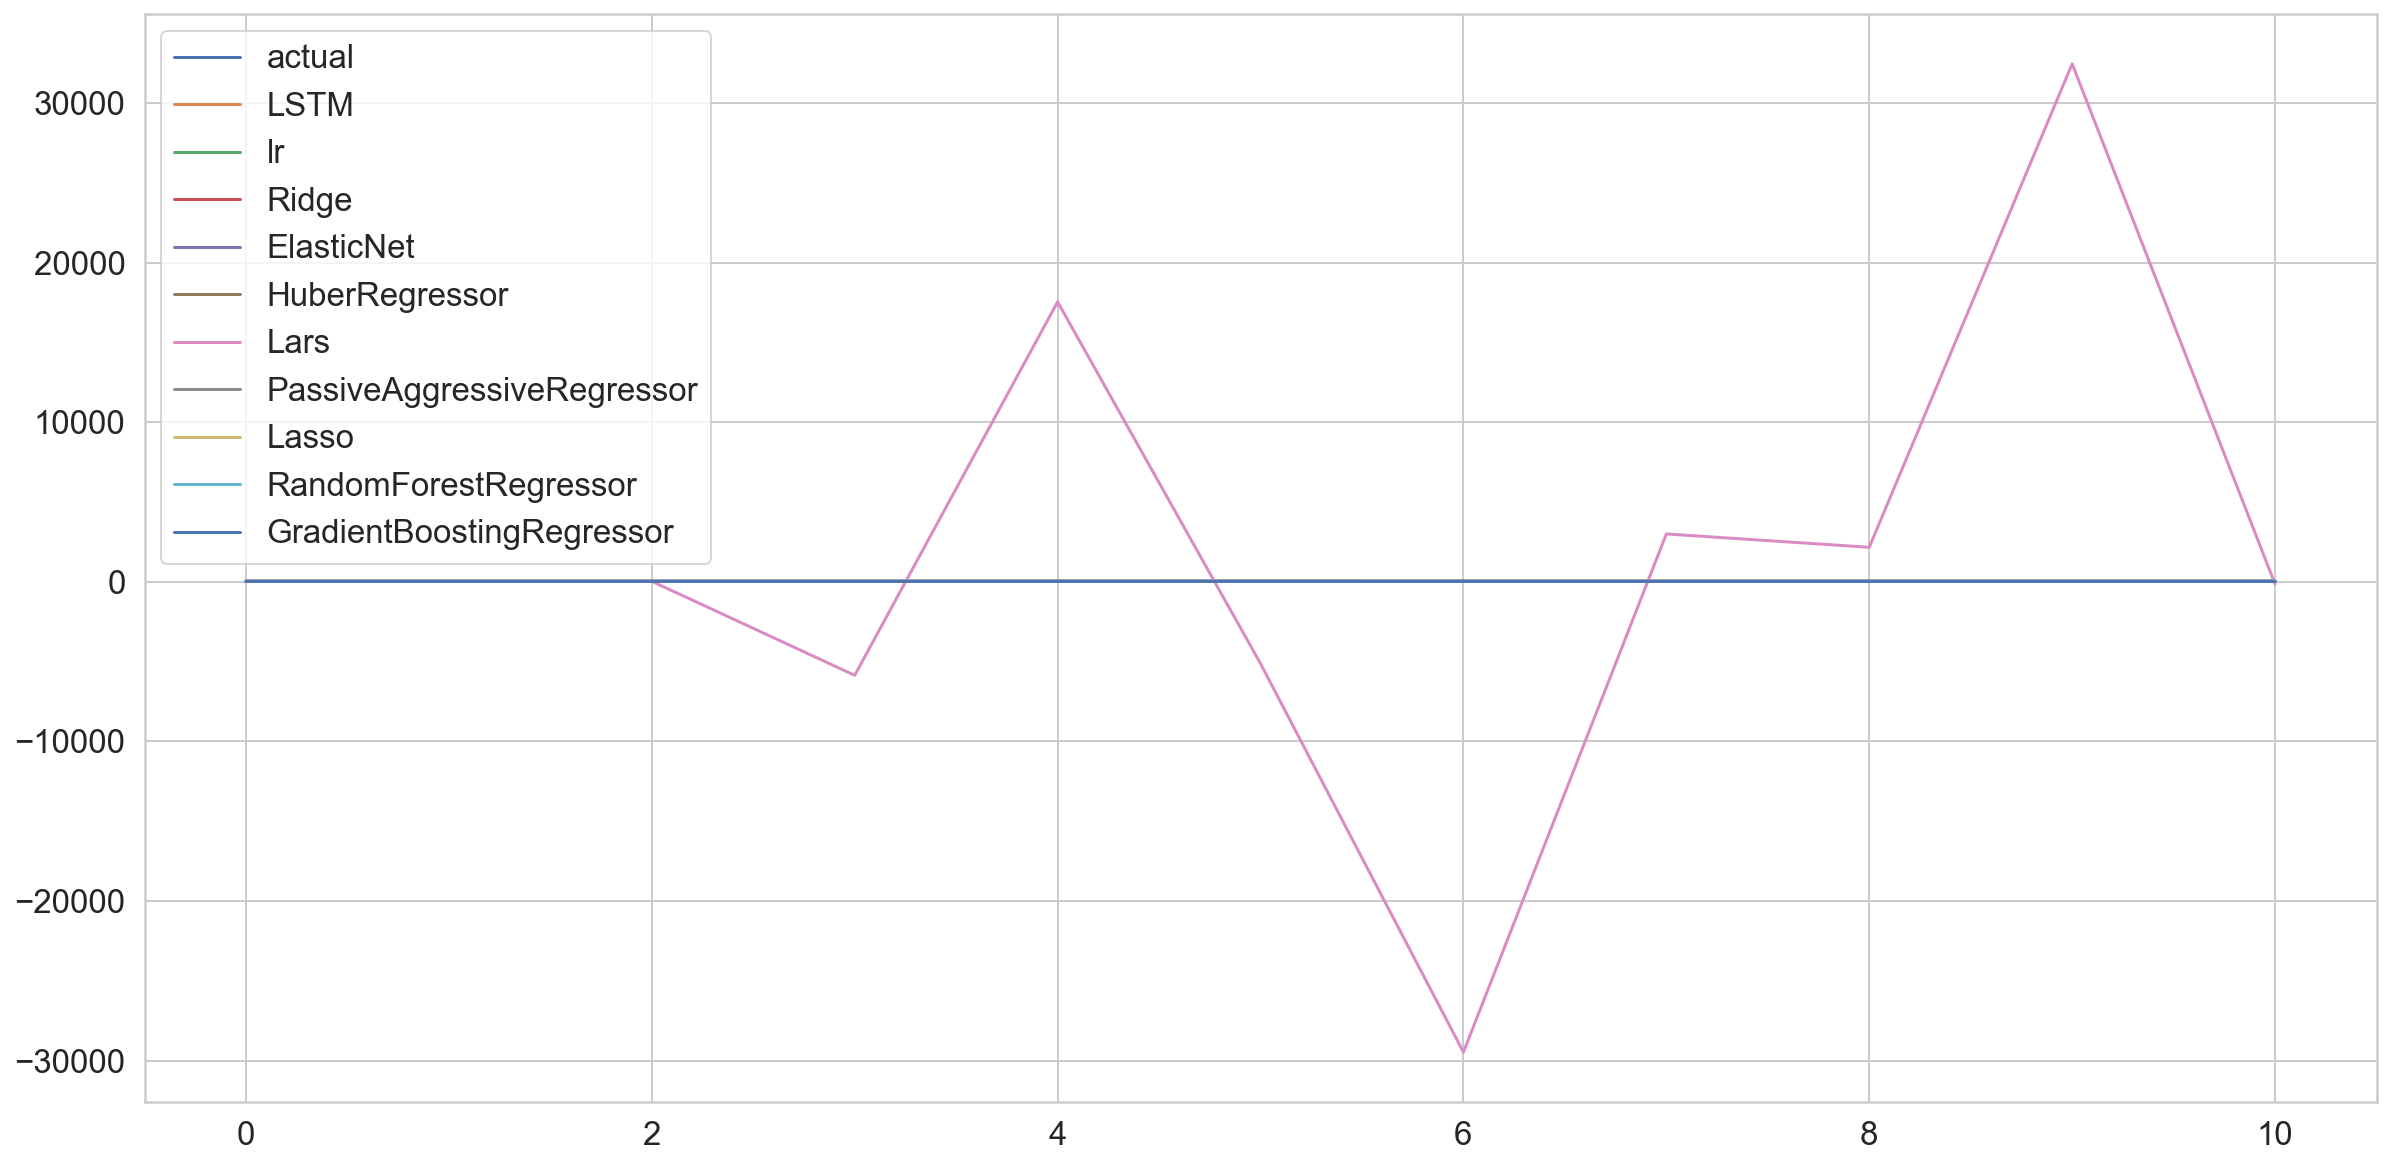

In [126]:
fig = plt.subplots( figsize=(20,10))
plt.plot(y_valid[:-1], label = "actual")
plt.plot(LSTM_valid_pred, label = "LSTM")
plt.plot(Lr_valid_pred, label = "lr")
plt.plot(Ridge_valid_pred, label = "Ridge")
plt.plot(ElasticNet_valid_pred, label = "ElasticNet")
plt.plot(HuberRegressor_valid_pred, label = "HuberRegressor")
plt.plot(Lars_valid_pred, label = "Lars")
# plt.plot(LassoLars_valid_pred, label = "LassoLars")
plt.plot(PassiveAggressiveRegressor_valid_pred, label = "PassiveAggressiveRegressor")
#plt.plot(RANSACRegressor_valid_pred, label = "RANSACRegressor")
# plt.plot(SGDRegressor_valid_pred, label = "SGDRegressor")
plt.plot(Lasso_valid_pred, label = "Lasso")
plt.plot(RandomForestRegressor_valid_pred, label = "RandomForestRegressor")
plt.plot(GradientBoostingRegressor_valid_pred, label = "GradientBoostingRegressor")
plt.legend(loc=2)
plt.show()

In [127]:
R2_score_valid_LSTM = r2_score(y_valid[:-1],nn_model.predict(X_valid))

In [128]:
R2_traininig_score_LSTM = r2_score(LSTM_training_outputs,nn_model.predict(LSTM_training_inputs))

In [129]:
R2_score_test_LSTM=r2_score(LSTM_test_outputs,nn_model.predict(LSTM_test_inputs))

In [130]:
R2_score_test_LSTM

-0.16250686937553205

In [131]:
R2_traininig_score_LSTM

0.9970598493152967

In [132]:
R2_score_valid_LSTM

-1.5800852729849355

In [133]:
models = ['LSTM','LR', 'lasso', 'ridge', 'en', 'huber', 'lars', 'pa', #'ranscac',
          'gboost', 'rt']
Training_R2=[R2_traininig_score_LSTM,lr.score(X_train,LSTM_training_outputs),
            lasso.score(X_train,LSTM_training_outputs),ridge.score(X_train,LSTM_training_outputs), 
            en.score(X_train,LSTM_training_outputs),huber.score(X_train,LSTM_training_outputs),
            lars.score(X_train,LSTM_training_outputs),
            pa.score(X_train,LSTM_training_outputs), #ranscac.score(X_train,LSTM_training_outputs),
             gboost.score(X_train,LSTM_training_outputs), rt.score(X_train,LSTM_training_outputs)]
Test_R2=[R2_score_test_LSTM,lr.score(X_test,LSTM_test_outputs),lasso.score(X_test,LSTM_test_outputs), 
         ridge.score(X_test,LSTM_test_outputs),en.score(X_test,LSTM_test_outputs), 
         huber.score(X_test,LSTM_test_outputs),lars.score(X_test,LSTM_test_outputs), 
         pa.score(X_test,LSTM_test_outputs), 
        # ranscac.score(X_test,LSTM_test_outputs), 
         gboost.score(X_test,LSTM_test_outputs),rt.score(X_test,LSTM_test_outputs)]
valid_R2=[R2_score_valid_LSTM,lr.score(X_valid_resaped, y_valid[:-1]),lasso.score(X_valid_resaped, y_valid[:-1]), 
         ridge.score(X_valid_resaped, y_valid[:-1]),en.score(X_valid_resaped, y_valid[:-1]), 
         huber.score(X_valid_resaped, y_valid[:-1]),lars.score(X_valid_resaped, y_valid[:-1]), 
         pa.score(X_valid_resaped, y_valid[:-1]), 
         #ranscac.score(X_valid_resaped, y_valid[:-1]), 
         gboost.score(X_valid_resaped, y_valid[:-1]),rt.score(X_valid_resaped, y_valid[:-1])]

In [134]:
R2_scores = pd.DataFrame({'models' : models,
                                'Training_R2' : Training_R2,
                                'Test_R2' :Test_R2  ,
                                'valid_R2':valid_R2 ,
                                }, 
                                columns=[ 'models','Training_R2','Test_R2','valid_R2'])

In [135]:
R2_scores

,models,Training_R2,Test_R2,valid_R2
0,LSTM,0.997060,-0.162507,-1.580085e+00
1,LR,0.997717,0.727485,9.305173e-01
2,lasso,0.997299,0.714510,8.888152e-01
3,ridge,0.997717,0.727918,7.616138e-01
4,en,0.997099,0.714414,8.982215e-01
5,huber,0.997633,0.735307,8.530780e-01
6,lars,-182.339663,-47.628011,-4.209715e+09
7,pa,0.997431,0.677124,5.141424e-01
8,gboost,0.998674,-1.245629,-3.573901e+00
9,rt,0.999452,-2.673673,-5.437604e+00


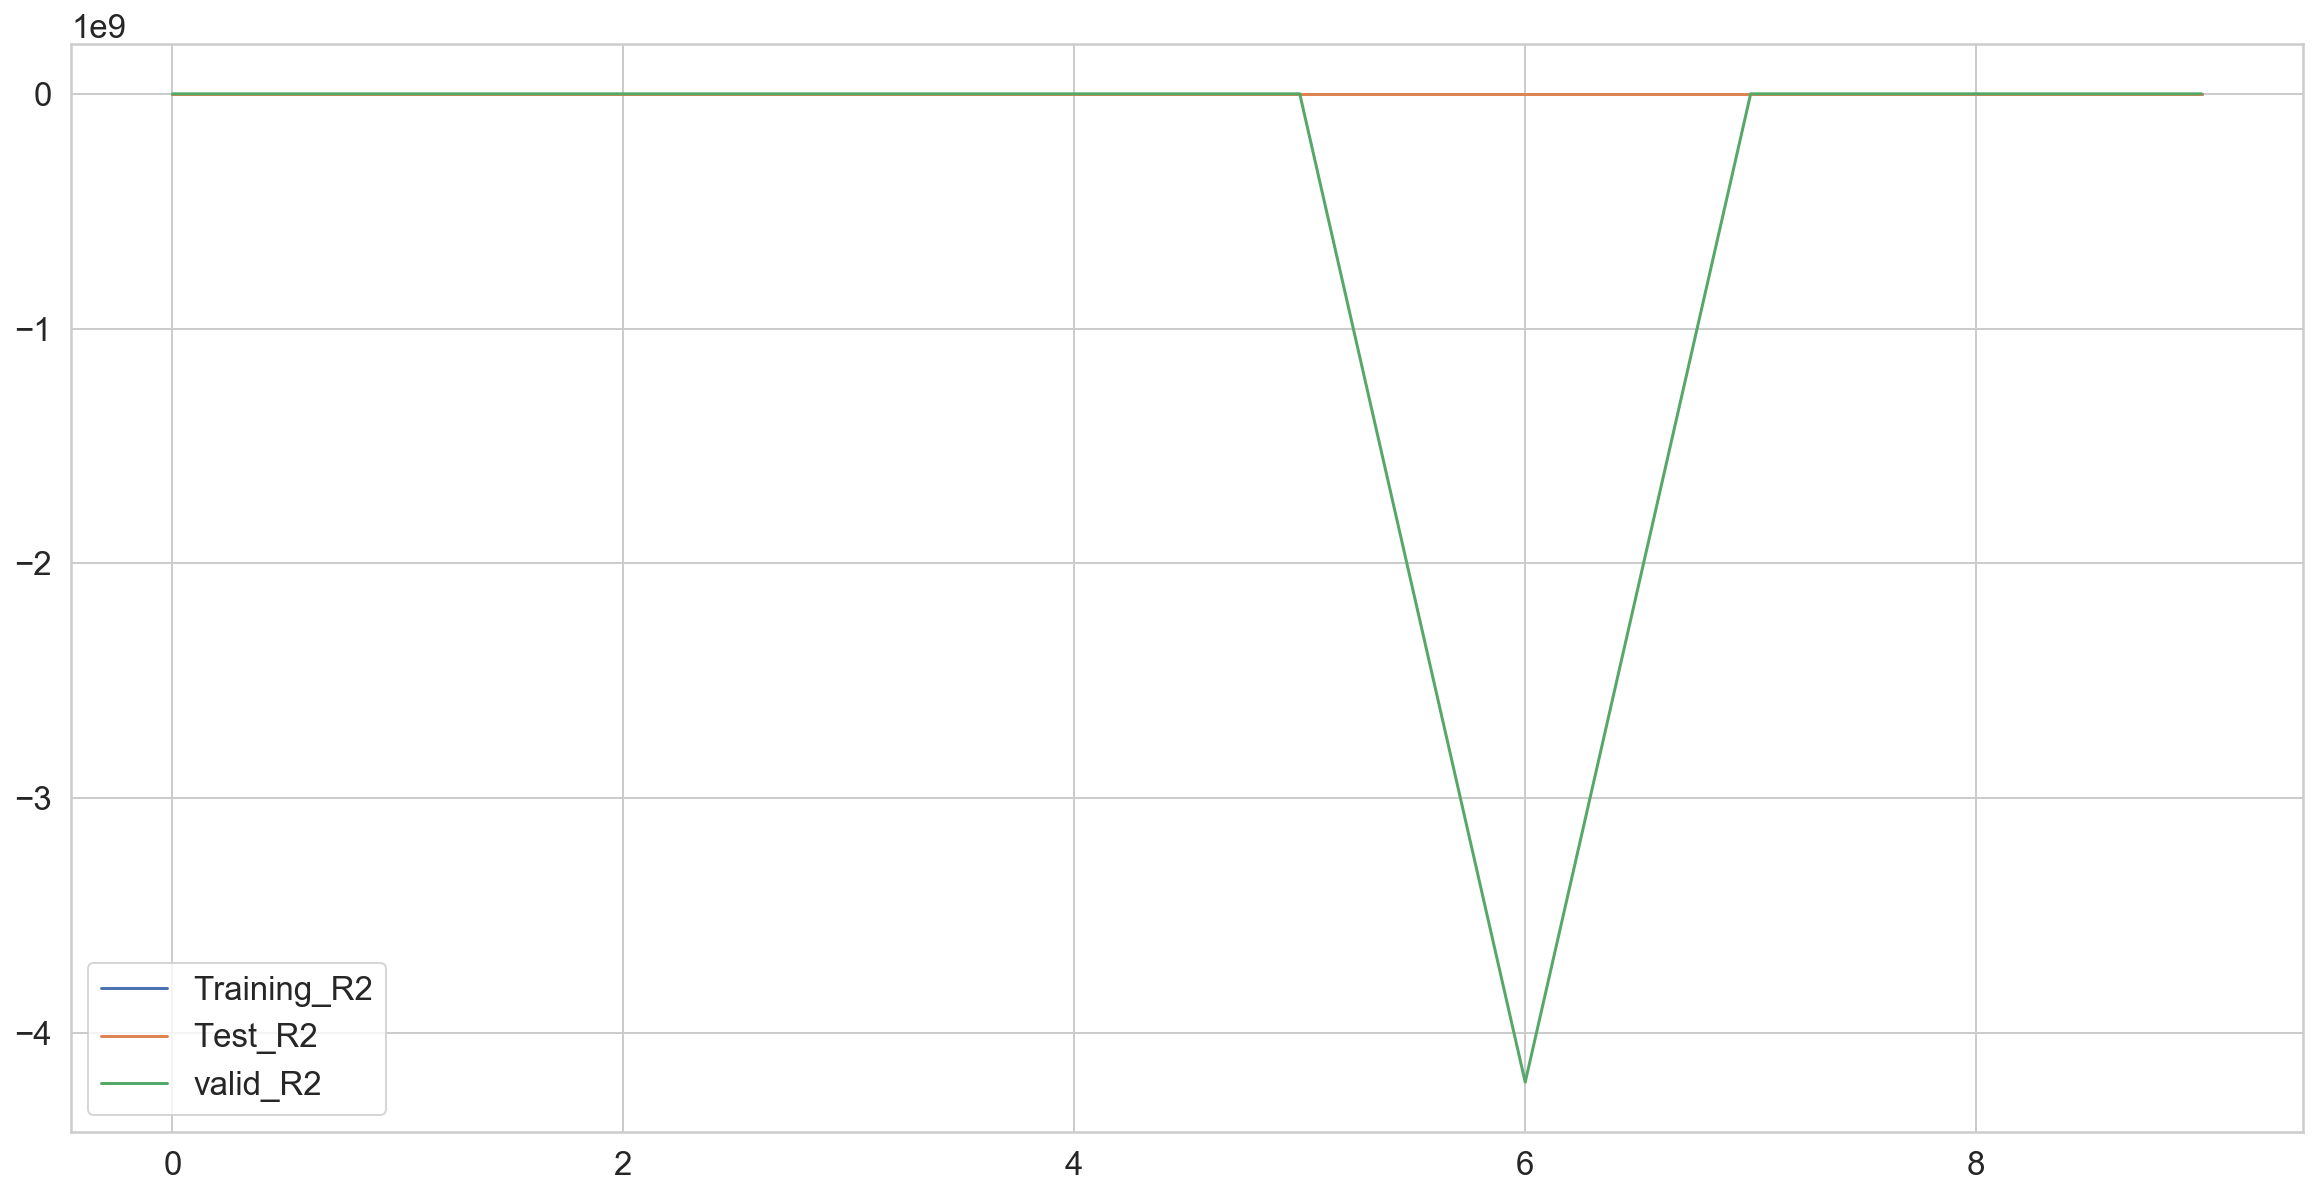

In [136]:
fig = plt.subplots( figsize=(20,10))
plt.plot(R2_scores['Training_R2'] ,label = "Training_R2")
plt.plot(R2_scores['Test_R2'] ,label = "Test_R2")
plt.plot(R2_scores['valid_R2'] ,label = "valid_R2")
xlabel=R2_scores['models']
plt.legend()
plt.show()